In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import random
import shapely
from shapely import Polygon, Point, affinity
from shapely.geometry import box

from shapely.ops import snap
from itertools import combinations

from sklearn.cluster import KMeans


[<Axes: > <Axes: > <Axes: > <Axes: >]


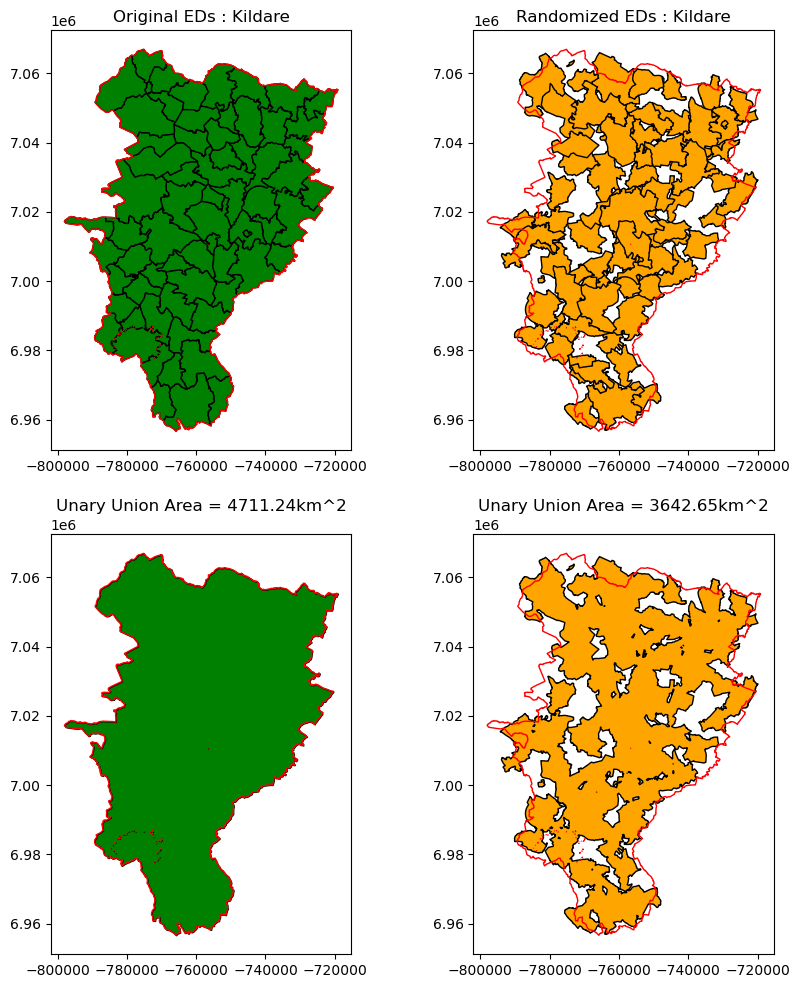

In [8]:
kildare = gpd.read_file("kildare.json").to_crs(3857)

#points_reversed = gpd.GeoDataFrame(pd.DataFrame(kildare['geometry'].centroid.reset_index(drop=True), columns=['geometry']).sort_index(ascending=False).reset_index(drop=True), geometry='geometry')
points_shuffled = gpd.GeoDataFrame(pd.DataFrame(kildare['geometry'].centroid.reset_index(drop=True), columns=['geometry']).sample(len(kildare)).reset_index(drop=True), geometry='geometry')

def move_gdf(gdf_poly, gdf_p):
    gdf_new = gdf_poly.copy()
    gdf_new['delta_x'] = gdf_p['geometry'].x - gdf_new['geometry'].centroid.x
    gdf_new['delta_y'] = gdf_p['geometry'].y - gdf_new['geometry'].centroid.y
    gdf_new['geometry'] = gdf_new.apply(lambda gdf: affinity.translate(gdf.loc['geometry'], xoff=gdf.loc['delta_x'], yoff=gdf.loc['delta_y']), axis=1)
    # adding in a random rotation element
    gdf_new['geometry'] = gdf_new.apply(lambda gdf: affinity.rotate(gdf.loc['geometry'], random.uniform(0,359), 'center'), axis=1)
    return gdf_new[gdf_new['geometry'].geom_type != 'Point']

#kildare_reversed = move_gdf(kildare, points_reversed)
kildare_shuffled = move_gdf(kildare, points_shuffled)

kildare_bounds = gpd.GeoSeries(kildare.unary_union, crs=3857)
#reversed_bounds = gpd.GeoSeries(kildare_reversed.unary_union, crs=3857)
shuffled_bounds = gpd.GeoSeries(kildare_shuffled.unary_union, crs=3857)

fig, axs = plt.subplots(2,2, figsize=(10,12))
axs_flat = axs.flatten()
print(axs_flat)

# Fig titles
axs_flat[0].set_title('Original EDs : Kildare')
#axs_flat[1].set_title('Reversed EDs : Kildare')
axs_flat[1].set_title('Randomized EDs : Kildare')
axs_flat[2].set_title(f'Unary Union Area = {kildare_bounds.area.item()/1000000:.2f}km^2')
#axs_flat[4].set_title(f'Unary Union Area = {reversed_bounds.area.item()/1000000:.2f}km^2')
axs_flat[3].set_title(f'Unary Union Area = {shuffled_bounds.area.item()/1000000:.2f}km^2')


# ED's
kildare.plot(ax=axs_flat[0], edgecolor='black', facecolor='green')
#kildare_reversed.plot(ax=axs_flat[1], edgecolor='black', facecolor='pink')
kildare_shuffled.plot(ax=axs_flat[1], edgecolor='black', facecolor='orange')

# ED Unary Union
kildare_bounds.plot(ax=axs_flat[2], edgecolor='black', facecolor='green')
#reversed_bounds.plot(ax=axs_flat[4], edgecolor='black', facecolor='pink')
shuffled_bounds.plot(ax=axs_flat[3], edgecolor='black', facecolor='orange')



for ax in axs_flat:
    kildare_bounds.plot(ax=ax, edgecolor='red', facecolor='none')

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 37 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


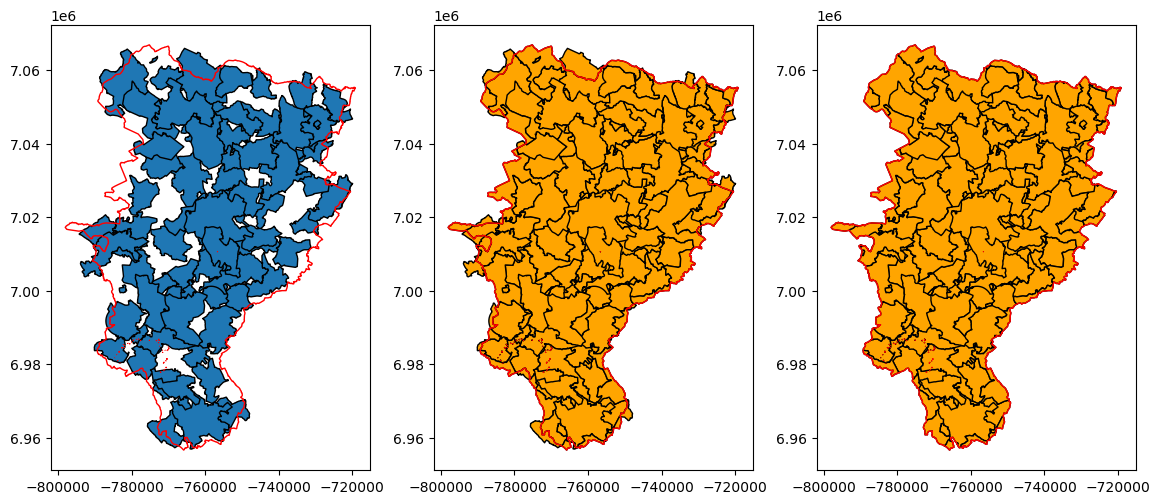

In [12]:
fig, ax = plt.subplots(1,3,figsize=(14, 12))

kildare_shuffled.plot(ax=ax[0], edgecolor='black')

overlay1 = gpd.GeoDataFrame(geometry=kildare_bounds).overlay(kildare_shuffled, how='union')
overlay2 = gpd.GeoDataFrame(geometry=kildare_bounds).overlay(overlay1, how='intersection')

overlay1.plot(ax=ax[1], edgecolor='black', facecolor='orange')
overlay2.plot(ax=ax[2], edgecolor='black', facecolor='orange')

for x in ax:
    kildare_bounds.plot(ax=x,edgecolor='red',facecolor='none')

In [20]:
def find_overlaps(gdf):
    """Returns a list of tuples identifying the geometries
    that overlap one another.
    """
    overlaps, retouch = [], {}
    for x, y in combinations(gdf.index.tolist(), 2):
        g_x = gdf.loc[x].geometry
        g_y = gdf.loc[y].geometry
        if g_x.intersects(g_y):
            overlaps.append([x, y])

    for t, b in overlaps:
        retouch.setdefault(t, []).append(b)

    return overlaps, retouch


def clip_overlaps_by_weight(gdf, col, tol=0.0000001):
    """Clips out overlapping geometries within a shapefile
    ranked by an attribute.
    """

    gdf.sort_values(by=col, axis=0, ascending=False, inplace=True)
    gdf.reset_index(drop=True,inplace=True)
    dupd = gdf.geometry.duplicated()
    if dupd.any():  # keep highest weighted duplicate, remove the rest
        gdf = gdf.loc[~dupd]

    overlaps, retouch = find_overlaps(gdf)

    for overlap in overlaps:
        print(gdf.loc[overlap])
        top, bot = gdf.loc[overlap].geometry
        try:
            bot = bot.difference(top)
        except:
            breakpoint()
        top = snap(top, bot, tol)
        gdf.loc[overlap, "geometry"] = gpd.GeoSeries([top, bot], index=overlap)

    for clipper, clip_list in retouch.items():
        for clipped in clip_list[:-1]:
            top, bot = gdf.loc[[clipper, clipped]].geometry
            gdf.loc[clipped, "geometry"] = snap(bot, top, tol)

    return gdf.sort_values(by="index").drop("index", axis=1)

test = clip_overlaps_by_weight(overlay2, 'id')

   level_0  index    id polldistr note  datecreate  \
0        0     76  67.0   LEIXLIP  NaN  2019-08-28   
1        1     66  67.0   LEIXLIP  NaN  2019-08-28   

                                                  qc                 lea_2019  \
0  Boundaries developed using OSi ED and townland...  Leixlip & Celbridge LEA   
1  Boundaries developed using OSi ED and townland...  Leixlip & Celbridge LEA   

    WGS84Lat  WGS84Long  delta_x  delta_y  \
0  53.367885  -6.508421      0.0      0.0   
1  53.367885  -6.508421      0.0      0.0   

                                            geometry  
0  MULTIPOLYGON (((-722779.872 7046331.950, -7227...  
1  MULTIPOLYGON (((-721609.573 7050419.906, -7216...  
    level_0  index    id polldistr note  datecreate  \
0         0     76  67.0   LEIXLIP  NaN  2019-08-28   
76       76     67   NaN       NaN  NaN         NaN   

                                                   qc  \
0   Boundaries developed using OSi ED and townland...   
76          

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:1815: FutureWarning: `unary_union` returned None due to all-None GeoSeries. In future, `unary_union` will return 'GEOMETRYCOLLECTION EMPTY' instead.
  merged_geom = block.unary_union
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/geodataframe.py:2469: UserWarning: `keep_geom_type=True` in overlay resulted in 37 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


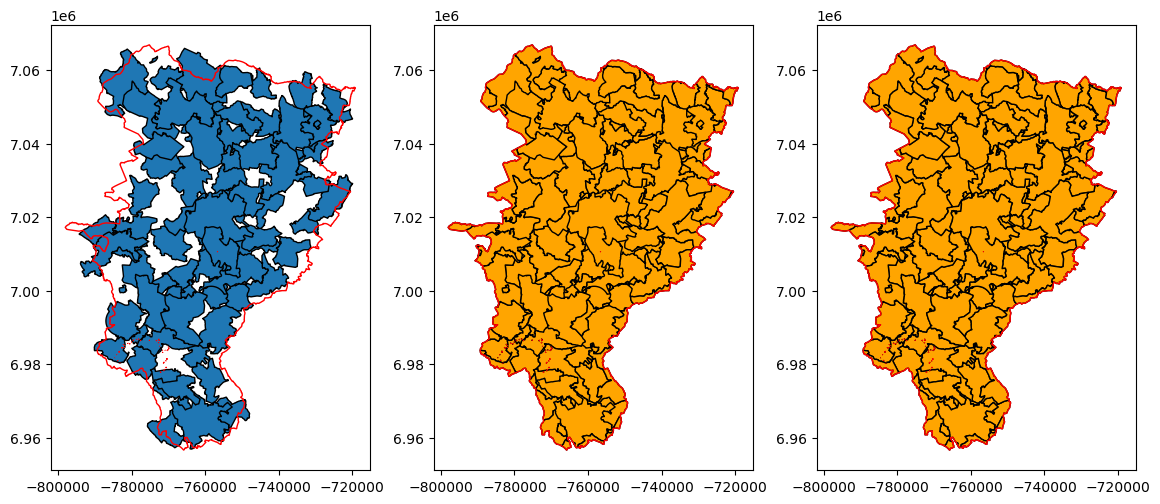

In [28]:
fig, ax = plt.subplots(1,3,figsize=(14, 12))

kildare_shuffled.plot(ax=ax[0], edgecolor='black')

overlay1 = gpd.GeoDataFrame(geometry=kildare_bounds).overlay(kildare_shuffled, how='union')
overlay2 = gpd.GeoDataFrame(geometry=kildare_bounds).overlay(overlay1, how='intersection')

overlay2.plot(ax=ax[1], edgecolor='black', facecolor='orange')
test.plot(ax=ax[2], edgecolor='black', facecolor='orange')

for x in ax:
    kildare_bounds.plot(ax=x,edgecolor='red',facecolor='none')

In [40]:
def multi_to_poly(multipoly):
    polygons = [poly for poly in multipoly.geoms]
    return gpd.GeoDataFrame(pd.DataFrame(polygons, columns=['geometry']), geometry='geometry')

def gdf_multi_to_poly(gdf):
    gdf_out = gpd.GeoDataFrame(pd.DataFrame([], columns=['geometry']),geometry='geometry', crs=gdf.crs)
    for i in range(gdf.shape[0]):
        if isinstance(gdf['geometry'][i], shapely.geometry.multipolygon.MultiPolygon):
            gdf_out = pd.concat([gdf_out, multi_to_poly(gdf['geometry'][i])],ignore_index=True)
        else:
            gdf_out = pd.concat([gdf_out, gdf.iloc[[i]]],ignore_index=True)
    return gdf_out

test_test = gdf_multi_to_poly(test)
test_test_test = gdf_multi_to_poly(test_test)

# need to look into why this has to be run twice to work
print(len(test.loc[test.geometry.type=='MultiPolygon']))
print(len(test_test.loc[test_test.geometry.type=='MultiPolygon']))
print(len(test_test_test.loc[test_test_test.geometry.type=='MultiPolygon']))

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Pseudo-Mercator (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))
/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/geopandas/array.py:1459: UserWarning: CRS 

42
20
0


                                              geometry          area
0    POLYGON ((-759096.337 6984403.619, -759091.344...  2.800435e+07
1    POLYGON ((-761827.467 6987797.959, -761828.004...  1.491058e+02
2    POLYGON ((-780140.896 6987010.492, -780153.084...  1.094240e+07
3    POLYGON ((-776405.001 6991263.423, -776397.191...  1.215230e+04
4    POLYGON ((-764104.213 7040555.960, -764106.895...  2.185363e+06
..                                                 ...           ...
247  POLYGON ((-784287.922 7018365.409, -784052.822...  7.877550e-10
248  POLYGON ((-783174.383 7019772.232, -783174.620...  1.385526e-11
250  POLYGON ((-726884.011 7041322.872, -726874.738...  5.619185e-10
251  POLYGON ((-722779.872 7046331.950, -722770.806...  1.503033e-09
252  POLYGON ((-722803.829 7046347.527, -722803.829...  2.402483e-10

[252 rows x 2 columns]
EPSG:3857


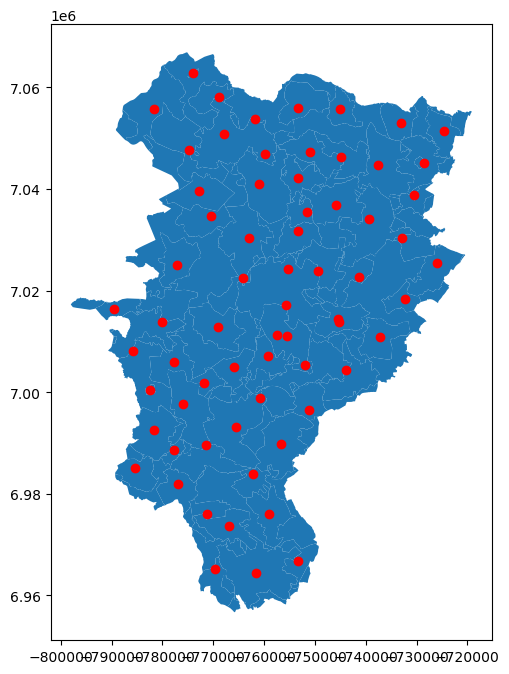

In [134]:
def multi_to_poly(gdf):
    polys = []
    for geom in gdf.geometry:
        if isinstance(geom, shapely.geometry.multipolygon.MultiPolygon):
            for y in geom.geoms:
                polys.append(y)
        else:
            polys.append(geom)
    return gpd.GeoDataFrame(geometry=polys, crs=3857)#.reset_index(drop=True)

test_polys = multi_to_poly(test)
test_polys.to_file("kildare_random_ED.geojson")

fig, ax = plt.subplots(1,1, figsize=(10,8))

test_polys.plot(ax=ax)
points_shuffled.plot(ax=ax, color='red')

test_polys['area'] = test_polys.area
test_polys = test_polys[~test_polys.geometry.is_empty]  

print(test_polys)

print(test.crs)

/home/paddy/miniconda3/envs/radian/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


    cluster                                           geometry
0         0  MULTIPOLYGON (((-741272.683 7038448.881, -7413...
1         1  POLYGON ((-761829.067 6987797.141, -761827.191...
2         2  POLYGON ((-765326.740 7016665.048, -765416.149...
3         3  POLYGON ((-767478.475 6964050.474, -767459.345...
4         4  POLYGON ((-781949.279 7045194.412, -781958.039...
..      ...                                                ...
72       72  POLYGON ((-773334.782 6970261.407, -773368.766...
73       73  POLYGON ((-725436.379 7032069.084, -725394.185...
74       74  POLYGON ((-778855.874 7008234.733, -778756.988...
75       75  POLYGON ((-768892.468 7029273.626, -768899.255...
76       76  POLYGON ((-782677.093 7047530.827, -782690.760...

[77 rows x 2 columns]


<Axes: >

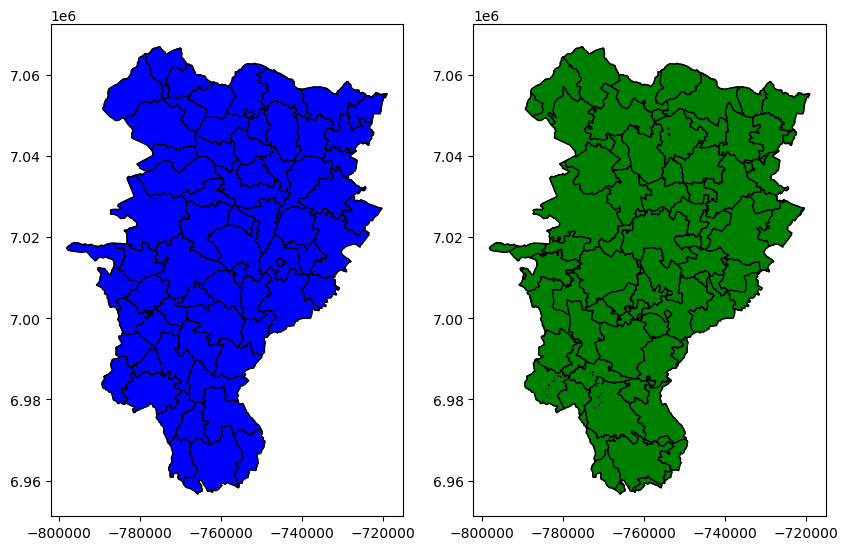

In [147]:
def poly_bb_ratio(poly):
    min_x, min_y, max_x, max_y = poly.bounds
    bb = gpd.GeoSeries(box(min_x, min_y, max_x, max_y, ccw=True))
    ratio = float(1/(poly.area/bb.area))
    if ratio < 1.8:
        return 1.8
    return ratio

def points_uniform(poly, num_points):
    min_x, min_y, max_x, max_y = poly.bounds
    poly_ratio = poly_bb_ratio(poly)
    poly_gdf = gpd.GeoDataFrame(pd.DataFrame([poly], columns=['geometry']), geometry='geometry', crs=3857)

    points = []
    # Generates points repeatedly with a uniform generation within the bounds of the polygon
    while len(points) < round(num_points * poly_ratio):
        points.append(Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)]))
    gdf = gpd.GeoDataFrame(pd.DataFrame(points, columns=['geometry']), geometry='geometry', crs=3857)
    gdf = gdf.sjoin(poly_gdf, predicate='within')
    gdf = gdf.drop(['index_right'], axis=1)

    return gdf.iloc[0:num_points].reset_index(drop=True)

def kmeans_polys(num_cluster, polys):
    # The geometries of the Shapely points are converted to a numpy array for use in the kmeans algorithm
    feature_coords = np.array([[e.x, e.y] for e in polys.centroid.geometry])

    # A kmeans object is created using the specified number of clusters
    kmeans = KMeans(num_cluster)
    kmeans.fit(feature_coords)

    # The cluster centres are stored as centroids, and this list is put into a GeoDataFrame and returned

    gdf = gpd.GeoDataFrame(pd.DataFrame(kmeans.labels_, columns=['cluster']), geometry=polys.geometry)

    return gdf

fig, ax = plt.subplots(1,2, figsize=(10,8))

kmeans_kildare = kmeans_polys(77, test_polys).sort_values('cluster').reset_index(drop=True)

print(kmeans_kildare.dissolve(by='cluster', as_index=False))

for x in ax:
    kildare_bounds.plot(ax=x, edgecolor='black', facecolor='none')

kildare.plot(ax=ax[0], edgecolor='black', facecolor='blue')
kmeans_kildare.dissolve(by='cluster', as_index=False).plot(ax=ax[1], edgecolor='black', facecolor='green')

